# Part 1

In [172]:
import matplotlib.pyplot as plt
import pandas as pandas
import numpy as np
import time as time
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

# Data Preparation

In [173]:
# load the data using Pandas.
insuranceData = pandas.read_csv ("insurance_dataset.csv")

In [174]:
# Define the categories for ordinal columns
exercise_frequency_categories = ['Never', 'Rarely', 'Occasionally', 'Frequently']
smoker_categories = ['no', 'yes']
region_categories = ['northeast', 'northwest', 'southeast', 'southwest']
medical_history_categories = ['Unknown', 'Diabetes', 'Heart disease', 'High blood pressure']
family_medical_history_categories = ['Unknown', 'Diabetes', 'Heart disease', 'High blood pressure']
occupation_categories = ['Unemployed', 'Student', 'Blue collar', 'White collar']
gender_categories = ['female', 'male']
coverage_level = ['Basic', 'Standard', 'Premium']

ordinal_category_list = [exercise_frequency_categories, smoker_categories, 
                         region_categories, medical_history_categories, family_medical_history_categories, 
                         occupation_categories, gender_categories, coverage_level]

ordinal_columns = ["exercise_frequency", "smoker", "region", 
                   "medical_history", "family_medical_history", "occupation", "gender", "coverage_level"]

# Replace 'nan' with 'Unknown' for medical history and family medical history
insuranceData["medical_history"] = insuranceData["medical_history"].fillna("Unknown")
insuranceData["family_medical_history"] = insuranceData["family_medical_history"].fillna("Unknown")

# Define the OrdinalEncoder with created categories
encoding = make_column_transformer((OrdinalEncoder(categories=ordinal_category_list), ordinal_columns))

transformed_data = encoding.fit_transform(insuranceData)

# Get the non-transformed data
unchanged_columns = ["age", "bmi", "children", "charges"]
unchanged_data = insuranceData[unchanged_columns].values

# Concatenate the transformed data with the numerical data
combined_data = np.concatenate((transformed_data, unchanged_data), axis=1)

# Create column names for the combined data
combined_column_names = ordinal_columns + unchanged_columns

# Create a DataFrame from the combined data
combined_df = pandas.DataFrame(combined_data, columns=combined_column_names)

columns_to_normalize = [col for col in combined_df.columns if col != 'coverage_level' and col != 'charges']

# Scale the columns to be between 1 and 0
scaler = MinMaxScaler()
combined_df[columns_to_normalize] = scaler.fit_transform(combined_df[columns_to_normalize])

# Print the modified data set
print(combined_df)

        exercise_frequency  smoker    region  medical_history  \
0                 0.000000     1.0  0.666667         0.333333   
1                 0.666667     1.0  0.333333         0.333333   
2                 0.666667     1.0  1.000000         0.000000   
3                 0.333333     0.0  0.333333         0.000000   
4                 0.333333     1.0  0.333333         0.333333   
...                    ...     ...       ...              ...   
999995            1.000000     0.0  0.000000         1.000000   
999996            1.000000     0.0  0.000000         0.000000   
999997            0.333333     1.0  0.000000         0.666667   
999998            0.666667     1.0  0.000000         1.000000   
999999            0.666667     1.0  0.000000         0.333333   

        family_medical_history  occupation  gender  coverage_level       age  \
0                     0.000000    0.666667     1.0             2.0  0.595745   
1                     1.000000    1.000000     0.0         

In [175]:
# Define the inputs and targets
combined_df = combined_df.sample(n=100000, random_state=42)
inputs =  combined_df.drop(['region', 'charges', 'coverage_level'], axis=1)
targets_coverage = combined_df["coverage_level"].values.astype(float)
targets_charge = combined_df["charges"].values.astype(float)
                        
# Split the data
inputs_train, inputs_test, target_coverage_train, target_coverage_test = train_test_split(
    inputs, targets_coverage, test_size=0.2, random_state=42)
inputs_train, inputs_test, target_charge_train, target_charge_test = train_test_split(
    inputs, targets_charge, test_size=0.2, random_state=42)

# Random Forest

Training time for models: 32.14921760559082 seconds
Charges MSE:  5114157.528659497
Coverage MSE:  0.7026893619614513
Charges MSE:  1586949.1513265716
Coverage MSE:  0.21952010572562358
Charges MSE:  1599469.2207828509
Coverage MSE:  0.21984582971655328
Charges MSE:  1614962.5293455361
Coverage MSE:  0.22118533786848074
Charges MSE:  1615553.6186703607
Coverage MSE:  0.22260115306122447


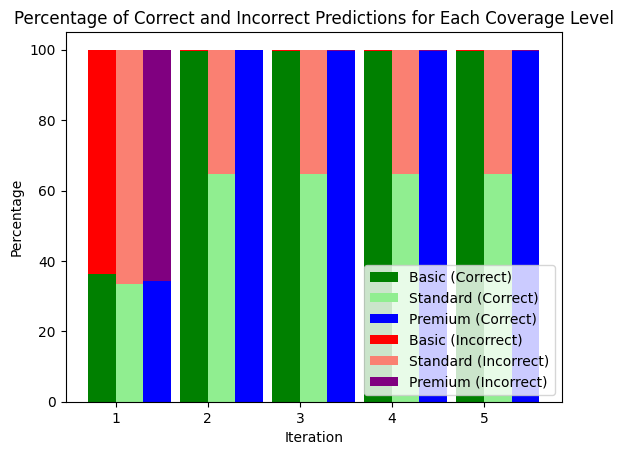

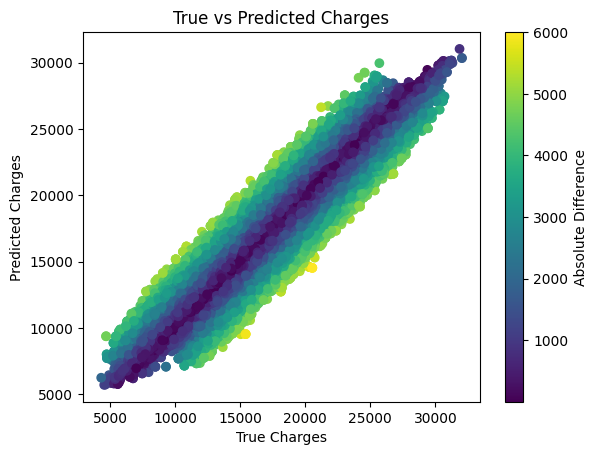

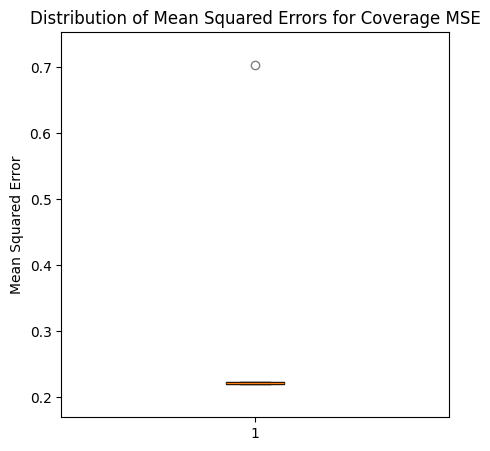

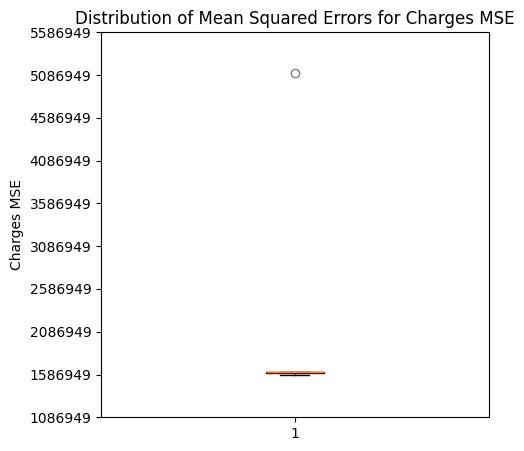

In [176]:
# Create arrays to store the results
MSECoverage = []
MSECharges = []
AllPredictionsCoverage = []
AllPredictionsCharges = []
AllCoverage = []
AllCharges = []

# Time before training
start_time = time.time()

# Create and train the model for coverage
rfcCoverage = RandomForestRegressor(n_estimators=70, max_depth=80, bootstrap = True, min_samples_split=2, min_samples_leaf=1, random_state=42)
rfcCoverage.fit(inputs_train, target_coverage_train)

# Create and train the model for charges
rfcCharges = RandomForestRegressor(n_estimators=70, max_depth=50, bootstrap = True, min_samples_split=2, min_samples_leaf=1, random_state=42)
rfcCharges.fit(inputs_train, target_charge_train)

#Time taken to train
training_time = time.time() - start_time
print("Training time for models:", training_time, "seconds")

# Loop predictions
for i in range(5):
    # Predict for coverage and then round the results to a digit either 1, 2 or 3
    coveragePrediction = rfcCoverage.predict(inputs_test)
    rounded_coveragePrediction = np.around(coveragePrediction)
    # Store the prediction and the actual value for use in the graphs below
    AllCoverage.append(target_coverage_test)
    AllPredictionsCoverage.append(rounded_coveragePrediction)

    # Predict for charges
    chargesPrediction = rfcCharges.predict(inputs_test)
    # Store the prediction and the actual value for the graphs below
    AllPredictionsCharges.append(chargesPrediction)
    AllCharges.append(target_charge_test)
    
    # Calculating Mean Squared Error for coverage
    errorMeanCoverage = mean_squared_error(target_coverage_test, coveragePrediction)
    
    # Calculating mean squared error for charge
    errorMeanCharge = mean_squared_error(target_charge_test, chargesPrediction)

    print("Charges MSE: ", errorMeanCharge)
    print("Coverage MSE: ", errorMeanCoverage)
    
    #Store the mean squared errors
    MSECoverage.append(errorMeanCoverage)
    MSECharges.append(errorMeanCharge)

    # Update the train-test split
    inputs_train, inputs_test, target_coverage_train, target_coverage_test = train_test_split(
        inputs, targets_coverage, test_size=0.2, random_state=43 + i)
    inputs_train, inputs_test, target_charge_train, target_charge_test = train_test_split(
        inputs, targets_charge, test_size=0.2, random_state=43 + i)

correct_percentages = []
incorrect_percentages = []

# Iterate through each prediction
for i in range(len(AllCoverage)):
    true_coverage = AllCoverage[i]
    predicted_coverage = AllPredictionsCoverage[i]

    # Initialize counters for correct and incorrect predictions for each coverage level
    correct_count = [0, 0, 0]
    incorrect_count = [0, 0, 0]

    # Compare each prediction with the true coverage value
    for j in range(len(true_coverage)):
        # Cast predicted_coverage[j] to int before using as an index
        if true_coverage[j] == int(predicted_coverage[j]):
            correct_count[int(true_coverage[j])] += 1
        else:
            # Cast predicted_coverage[j] to int before using as an index
            incorrect_count[int(predicted_coverage[j])] += 1

    # Calculate the total number of predictions for each coverage level
    total_predictions = [correct + incorrect for correct, incorrect in zip(correct_count, incorrect_count)]

    # Calculate the percentage of correct and incorrect predictions
    correct_percentage = [correct / total * 100 if total != 0 else 0 for correct, total in zip(correct_count, total_predictions)]
    incorrect_percentage = [incorrect / total * 100 if total != 0 else 0 for incorrect, total in zip(incorrect_count, total_predictions)]

    # Append the percentages to the lists
    correct_percentages.append(correct_percentage)
    incorrect_percentages.append(incorrect_percentage)

# Plotting the percentages of correct and incorrect predictions for each coverage level
bar_width = 0.30
index = np.arange(len(AllCoverage))

# Convert the lists to numpy arrays for plotting
correct_percentages = np.array(correct_percentages)
incorrect_percentages = np.array(incorrect_percentages)

# Plot the bars
plt.bar(index, correct_percentages[:, 0], bar_width, label='Basic (Correct)', color='green')
plt.bar(index + bar_width, correct_percentages[:, 1], bar_width, label='Standard (Correct)', color='lightgreen')
plt.bar(index + bar_width + bar_width, correct_percentages[:, 2], bar_width, label='Premium (Correct)', color='blue')

plt.bar(index, incorrect_percentages[:, 0], bar_width, bottom=correct_percentages[:, 0], label='Basic (Incorrect)', color='red')
plt.bar(index + bar_width, incorrect_percentages[:, 1], bar_width, bottom=correct_percentages[:, 1], label='Standard (Incorrect)', color='salmon')
plt.bar(index + bar_width + bar_width, incorrect_percentages[:, 2], bar_width, bottom=correct_percentages[:, 2], label='Premium (Incorrect)', color='purple')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Percentage')
plt.title('Percentage of Correct and Incorrect Predictions for Each Coverage Level')
plt.xticks(index + bar_width / 2, [str(i+1) for i in range(len(AllCoverage))])
plt.legend()
plt.show()

# Convert lists to numpy arrays
AllCharges_array = np.array(AllCharges)
AllPredictionsCharges_array = np.array(AllPredictionsCharges)

# Calculate the absolute difference between true and predicted charges
difference = np.abs(AllCharges_array - AllPredictionsCharges_array)

# Plotting true vs predicted charges with different colors based on the difference
plt.scatter(AllCharges_array, AllPredictionsCharges_array, c=difference, cmap='viridis')
plt.xlabel('True Charges')
plt.ylabel('Predicted Charges')

# Adding color bar for reference
plt.colorbar(label='Absolute Difference')
plt.title('True vs Predicted Charges')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_coverage = ax.boxplot(MSECoverage, patch_artist=True, boxprops=dict(facecolor='skyblue'))

# Set y-axis limit to customize the scale
ax.set_ylim(min(MSECoverage) - 0.05, max(MSECoverage) + 0.05)

# Set y-axis label and title
ax.set_ylabel('Mean Squared Error')
ax.set_title('Distribution of Mean Squared Errors for Coverage MSE')

# Set color for outliers
for flier in bp_coverage['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_charges = ax.boxplot(MSECharges, patch_artist=True, boxprops=dict(facecolor='skyblue'))

ax.set_ylabel('Charges MSE')
ax.set_title('Distribution of Mean Squared Errors for Charges MSE')

# Set color for outliers
for flier in bp_charges['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Set the y-axis tick values and labels
plt.yticks(np.arange(min(MSECharges) - 500000, max(MSECharges) + 500000, step=500000), ['{:.0f}'.format(y) for y in np.arange(min(MSECharges) - 500000, max(MSECharges) + 500000, step=500000)])

# Show the plot
plt.show()

# Analysis of Random Forest

## Coverage
The coverage means square error (MSE) shows to be very consistent for the most part however there is an anomaly that occurs within the first iteration of testing. The results are always around 0.22 but the anomaly has a value of 0.7. This is shown in the box plot where you can see the mean down by the 0.22 readings whilst the anomaly is around the 0.7 area. The highest result that is not an anomaly is 0.222 whilst the lowest is 0.217 however these cannot be seen clearly on the box plot due to the large range of the total set of MSE values. Despite this the Random Forest method seems to have been very effective.

## Charges
The charges MSE values show a similar pattern as the coverage MSE with the values being between 158000 and 1600000 apart from the MSE of the anomaly iteration which has a value of about 5090000. Despite this anomaly once again the MSE seems to stay within a very close range creating clear trend however the MSE for the charges is significantly higher than that for the coverages which i can only assume is due to the fact that the chance of an incorrect prediction is greater and the difference between the correct and predicted value can be a lot bigger.


# Neural Network

Training time for models: 225.31414318084717 seconds
Mean Squared Error Coverage (Iteration 1): 0.6878523250082786
Mean Squared Error Charges (Iteration 1): 10606788.72586965
Mean Squared Error Coverage (Iteration 2): 0.652416983119486
Mean Squared Error Charges (Iteration 2): 10535850.393387625
Mean Squared Error Coverage (Iteration 3): 0.6449154596770929
Mean Squared Error Charges (Iteration 3): 10546180.676486729
Mean Squared Error Coverage (Iteration 4): 0.6491107078353442
Mean Squared Error Charges (Iteration 4): 10536230.63635342
Mean Squared Error Coverage (Iteration 5): 0.6473595196686524
Mean Squared Error Charges (Iteration 5): 10461672.171845516


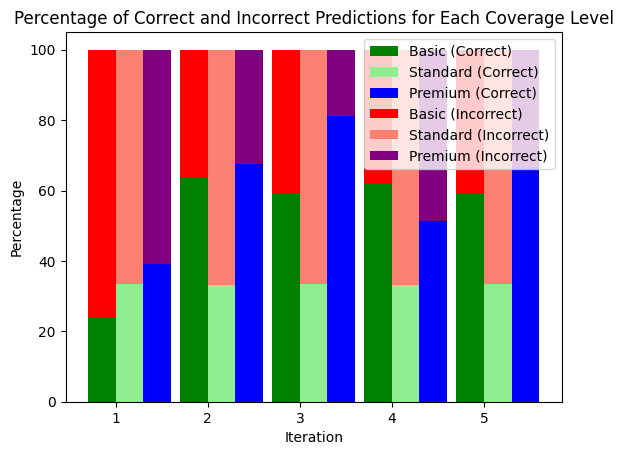

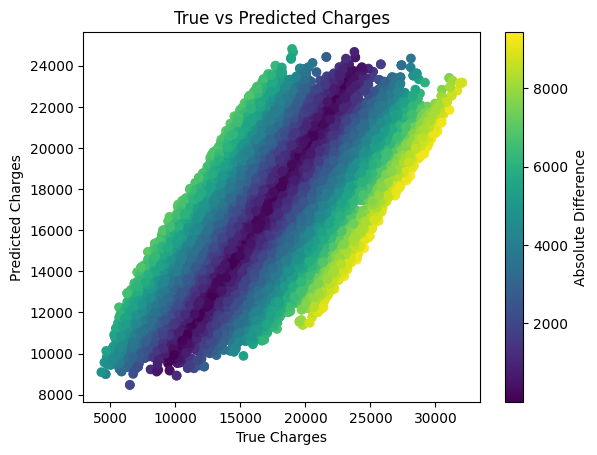

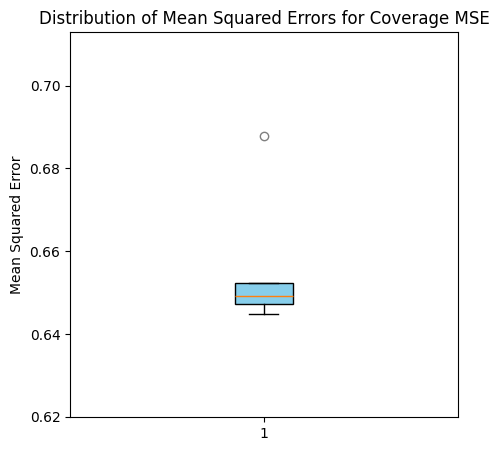

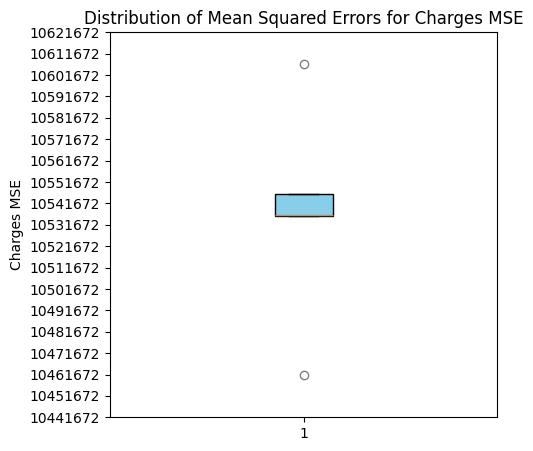

In [177]:
MSECoverage = []
MSECharges = []
AllPredictionsCoverage = []
AllPredictionsCharges = []
AllCoverage = []
AllCharges = []

# Time before training
start_time = time.time()

coverageMLP = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.001, max_iter=1000, learning_rate_init=0.001, random_state=42)
coverageMLP.fit(inputs_train, target_coverage_train)

chargesMLP = MLPRegressor(hidden_layer_sizes=(500, 250), activation='relu', alpha=0.001, max_iter=1000, learning_rate_init=0.001, random_state=42)
chargesMLP.fit(inputs_train, target_charge_train)

#Time taken to train
training_time = time.time() - start_time
print("Training time for models:", training_time, "seconds")

for i in range(5):
    coveragePrediction = coverageMLP.predict(inputs_test)
    rounded_coveragePrediction = np.around(coveragePrediction)
    AllCoverage.append(target_coverage_test)
    AllPredictionsCoverage.append(rounded_coveragePrediction)

    chargesPrediction = chargesMLP.predict(inputs_test)
    AllPredictionsCharges.append(chargesPrediction)
    AllCharges.append(target_charge_test)
    
    # Calculating Mean Squared Error for coverage
    errorMeanCoverage = mean_squared_error(target_coverage_test, coveragePrediction)
    
    # Calculating Mean Squared Error for charge
    errorMeanCharge = mean_squared_error(target_charge_test, chargesPrediction)

    MSECoverage.append(errorMeanCoverage)
    MSECharges.append(errorMeanCharge)
    
    print("Mean Squared Error Coverage (Iteration {}): {}".format(i+1, errorMeanCoverage))
    print("Mean Squared Error Charges (Iteration {}): {}".format(i+1, errorMeanCharge))

    inputs_train, inputs_test, target_coverage_train, target_coverage_test = train_test_split(
        inputs, targets_coverage, test_size=0.2, random_state=43 + i)
    inputs_train, inputs_test, target_charge_train, target_charge_test = train_test_split(
        inputs, targets_charge, test_size=0.2, random_state=43 + i)

correct_percentages = []
incorrect_percentages = []

# Iterate through each prediction
for i in range(len(AllCoverage)):
    true_coverage = AllCoverage[i]
    predicted_coverage = AllPredictionsCoverage[i]

    # Initialize counters for correct and incorrect predictions for each coverage level
    correct_count = [0, 0, 0]
    incorrect_count = [0, 0, 0]

    # Compare each prediction with the true coverage value
    for j in range(len(true_coverage)):
        # Cast predicted_coverage[j] to int before using as an index
        if true_coverage[j] == int(predicted_coverage[j]):
            correct_count[int(true_coverage[j])] += 1
        else:
            # Cast predicted_coverage[j] to int before using as an index
            incorrect_count[int(predicted_coverage[j])] += 1

    # Calculate the total number of predictions for each coverage level
    total_predictions = [correct + incorrect for correct, incorrect in zip(correct_count, incorrect_count)]

    # Calculate the percentage of correct and incorrect predictions
    correct_percentage = [correct / total * 100 if total != 0 else 0 for correct, total in zip(correct_count, total_predictions)]
    incorrect_percentage = [incorrect / total * 100 if total != 0 else 0 for incorrect, total in zip(incorrect_count, total_predictions)]

    # Append the percentages to the lists
    correct_percentages.append(correct_percentage)
    incorrect_percentages.append(incorrect_percentage)

# Plotting the percentages of correct and incorrect predictions for each coverage level
bar_width = 0.30
index = np.arange(len(AllCoverage))

# Convert the lists to numpy arrays for plotting
correct_percentages = np.array(correct_percentages)
incorrect_percentages = np.array(incorrect_percentages)

# Plot the bars
plt.bar(index, correct_percentages[:, 0], bar_width, label='Basic (Correct)', color='green')
plt.bar(index + bar_width, correct_percentages[:, 1], bar_width, label='Standard (Correct)', color='lightgreen')
plt.bar(index + bar_width + bar_width, correct_percentages[:, 2], bar_width, label='Premium (Correct)', color='blue')

plt.bar(index, incorrect_percentages[:, 0], bar_width, bottom=correct_percentages[:, 0], label='Basic (Incorrect)', color='red')
plt.bar(index + bar_width, incorrect_percentages[:, 1], bar_width, bottom=correct_percentages[:, 1], label='Standard (Incorrect)', color='salmon')
plt.bar(index + bar_width + bar_width, incorrect_percentages[:, 2], bar_width, bottom=correct_percentages[:, 2], label='Premium (Incorrect)', color='purple')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Percentage')
plt.title('Percentage of Correct and Incorrect Predictions for Each Coverage Level')
plt.xticks(index + bar_width / 2, [str(i+1) for i in range(len(AllCoverage))])
plt.legend()
plt.show()

# Convert lists to numpy arrays
AllCharges_array = np.array(AllCharges)
AllPredictionsCharges_array = np.array(AllPredictionsCharges)

# Calculate the absolute difference between true and predicted charges
difference = np.abs(AllCharges_array - AllPredictionsCharges_array)

# Plotting true vs predicted charges with different colors based on the difference
plt.scatter(AllCharges_array, AllPredictionsCharges_array, c=difference, cmap='viridis')
plt.xlabel('True Charges')
plt.ylabel('Predicted Charges')

# Adding color bar for reference
plt.colorbar(label='Absolute Difference')
plt.title('True vs Predicted Charges')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_coverage = ax.boxplot(MSECoverage, patch_artist=True, boxprops=dict(facecolor='skyblue'))

# Set y-axis limit to customize the scale
ax.set_ylim(min(MSECoverage) - 0.025, max(MSECoverage) + 0.025)

# Set y-axis label and title
ax.set_ylabel('Mean Squared Error')
ax.set_title('Distribution of Mean Squared Errors for Coverage MSE')

# Set color for outliers
for flier in bp_coverage['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_charges = ax.boxplot(MSECharges, patch_artist=True, boxprops=dict(facecolor='skyblue'))

ax.set_ylabel('Charges MSE')
ax.set_title('Distribution of Mean Squared Errors for Charges MSE')

# Set color for outliers
for flier in bp_charges['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Set the y-axis tick values and labels
plt.yticks(np.arange(min(MSECharges) - 20000, max(MSECharges) + 20000, step= 10000), ['{:.0f}'.format(y) for y in np.arange(min(MSECharges) - 20000, max(MSECharges) + 20000, step=10000)])

# Show the plot
plt.show()

# Analysis of Neural Network

## Coverage
The coverage MSE values were fairly consistent throughout each iteration with most values being within 0.1 of each other however it is also quite high. Predictions seem to favour standard coverage and are less likely to predict basic or premium coverage leading to a larger number of incorrect predictions. The box plot shows that there was one anomaly which was in the first iteration but the difference between the anomaly and the rest of the MSE values was only about 0.3 which is far less than the difference found in random forest.
## Charges
The MSE values for charges showed more range with 2 anomalies appearing. Despite the anomalies the range of the values is only about 200000 which is not that large considering the size of the MSE values given. The MSEs are all around 10.5 million which is very large with the showing me that the accuracy of the predictions for the charges is not very good.


# Support Vector Machine

Training time for models: 4733.632098436356 seconds
Mean Squared Error Coverage (Iteration 1): 1.2272196389190964
Mean Squared Error Charges (Iteration 1): 10617238.59116942
Mean Squared Error Coverage (Iteration 2): 0.39547466353164246
Mean Squared Error Charges (Iteration 2): 10541766.53543697
Mean Squared Error Coverage (Iteration 3): 0.38556616215432143
Mean Squared Error Charges (Iteration 3): 10552054.461961295
Mean Squared Error Coverage (Iteration 4): 0.3785258323943397
Mean Squared Error Charges (Iteration 4): 10533538.316313129
Mean Squared Error Coverage (Iteration 5): 0.38299761645316105
Mean Squared Error Charges (Iteration 5): 10466478.832930353


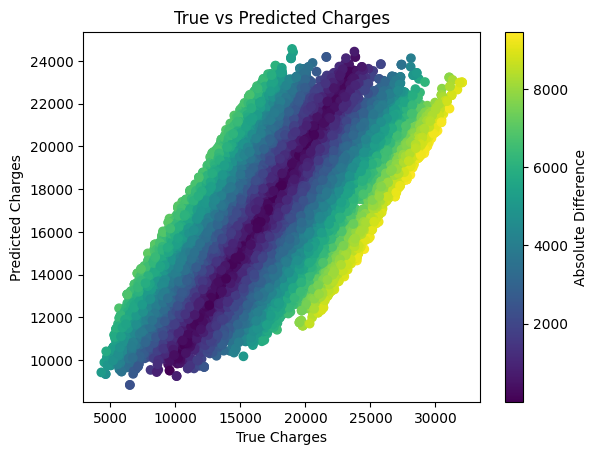

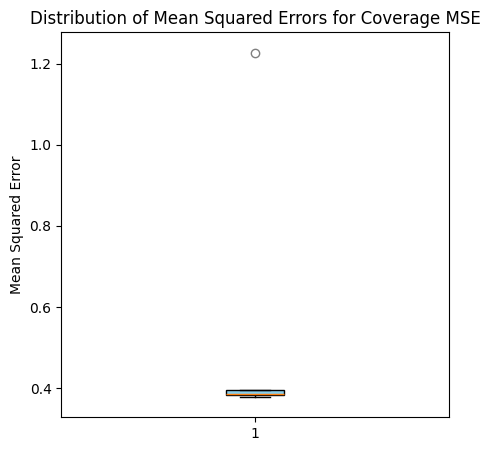

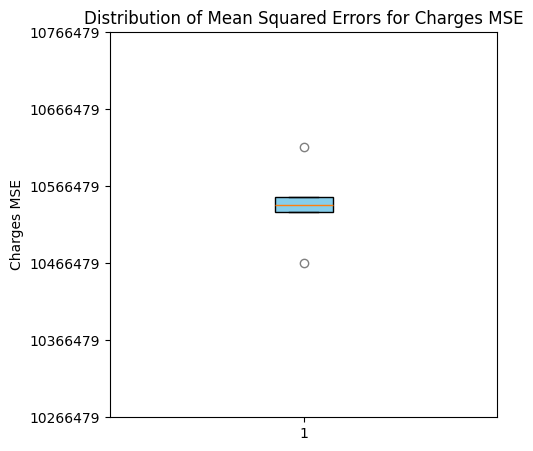

In [179]:
MSECoverage = []
MSECharges = []
AllPredictionsCoverage = []
AllPredictionsCharges = []
AllCoverage = []
AllCharges = []

# Time before training
start_time = time.time()

# Classifier: SVM for classification
coverageSVR = svm.SVR(kernel='rbf', C=10, gamma = 10)
coverageSVR.fit(inputs_train, target_coverage_train)

# Regressor: SVM for regression
chargeSVR = svm.SVR(kernel='linear', C=10)
chargeSVR.fit(inputs_train, target_charge_train)

#Time taken to train
training_time = time.time() - start_time
print("Training time for models:", training_time, "seconds")

for i in range(5):
    coveragePrediction = coverageSVR.predict(inputs_test)
    rounded_coveragePrediction = np.around(coveragePrediction)
    AllCoverage.append(target_coverage_test)
    AllPredictionsCoverage.append(rounded_coveragePrediction)

    chargesPrediction = chargeSVR.predict(inputs_test)
    AllPredictionsCharges.append(chargesPrediction)
    AllCharges.append(target_charge_test)
    
    # Calculating Mean Squared Error for coverage
    errorMeanCoverage = mean_squared_error(target_coverage_test, coveragePrediction)
    
    # Calculating Mean Squared Error for charge
    errorMeanCharge = mean_squared_error(target_charge_test, chargesPrediction)

    MSECoverage.append(errorMeanCoverage)
    MSECharges.append(errorMeanCharge)
    
    print("Mean Squared Error Coverage (Iteration {}): {}".format(i+1, errorMeanCoverage))
    print("Mean Squared Error Charges (Iteration {}): {}".format(i+1, errorMeanCharge))

    # Update the train-test split
    inputs_train, inputs_test, target_coverage_train, target_coverage_test = train_test_split(
        inputs, targets_coverage, test_size=0.2, random_state=43 + i)
    inputs_train, inputs_test, target_charge_train, target_charge_test = train_test_split(
        inputs, targets_charge, test_size=0.2, random_state=43 + i)
    
# Convert lists to numpy arrays
AllCharges_array = np.array(AllCharges)
AllPredictionsCharges_array = np.array(AllPredictionsCharges)

# Calculate the absolute difference between true and predicted charges
difference = np.abs(AllCharges_array - AllPredictionsCharges_array)

# Plotting true vs predicted charges with different colors based on the difference
plt.scatter(AllCharges_array, AllPredictionsCharges_array, c=difference, cmap='viridis')
plt.xlabel('True Charges')
plt.ylabel('Predicted Charges')

# Adding color bar for reference
plt.colorbar(label='Absolute Difference')
plt.title('True vs Predicted Charges')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_coverage = ax.boxplot(MSECoverage, patch_artist=True, boxprops=dict(facecolor='skyblue'))

# Set y-axis limit to customize the scale
ax.set_ylim(min(MSECoverage) - 0.05, max(MSECoverage) + 0.05)

# Set y-axis label and title
ax.set_ylabel('Mean Squared Error')
ax.set_title('Distribution of Mean Squared Errors for Coverage MSE')

# Set color for outliers
for flier in bp_coverage['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

# Create box plot for MSECoverage and set color
bp_charges = ax.boxplot(MSECharges, patch_artist=True, boxprops=dict(facecolor='skyblue'))

ax.set_ylabel('Charges MSE')
ax.set_title('Distribution of Mean Squared Errors for Charges MSE')

# Set color for outliers
for flier in bp_charges['fliers']:
    flier.set(marker='o', color='skyblue', alpha=0.5)  # Change color and transparency as needed

# Set the y-axis tick values and labels
plt.yticks(np.arange(min(MSECharges) - 200000, max(MSECharges) + 200000, step=100000), ['{:.0f}'.format(y) for y in np.arange(min(MSECharges) - 200000, max(MSECharges) + 200000, step=100000)])

# Show the plot
plt.show()

# Analysis of Support Vector Machine

## Coverage
The MSEs for the coverage predicted by the support vector machine follow a similar trend to the Random Forest model with an anomaly at the start followed by very close MSE values afterwards. The anomaly MSE is about 1.23 which is very high however after that the MSE drops to about 0.37 to 0.4 for all other iterations. The close range of MSE values shows that this model is fairly reliable.
## Charges
The results for charges MSE results almost identical to the results from the neural network with 2 anomalies and 3 close results. The results once again range from 10600000 to 10400000 with an average of about 10.5 million. This shows that the model is not very good at predicting the charges and should be classed as unreliable for this part of the ask.


# Analysis Overall

The random forest was the best model for this task as for both the MSE for coverage and the MSE for charges were the lowest out of all of the models. They were also more consistent than the other 2 models' MSE values when ignoring anomalies. Both of these factors are very important to consider however it is also worth noting that the random forest model takes significantly less time to run to get a much better result due to the simplicity of the models learning stile.

I believe that he neural network and the support vector machine are very similar to each other in quality as the results that came from the support vector machine took almost 19 times as long to train for and the results then took longer to be produced after training as well. On the other hand, if I were to only consider the MSE values then the neural network is clearly worse with a significantly higher MSE for coverages and the same values for the charges. Take this into account I believe that the support vector machine is marginally better as the time taken to train and run is not as big of a concern as poor results at the end of the training.


# Part 2

In [ ]:
import random
import copy

# Read Data

In [ ]:
#Open and read the file
surgeriesList = {}
with open("Surgery.txt", 'r') as file:
    for line in file:
        surgery, surgeon, surgeryNum, anaethetist = line.strip().split('|')
        surgeriesList[surgery] = {'surgeon': surgeon, 'surgeries': int(surgeryNum), 'anaethetist': anaethetist == 'Yes'}

# Generate Random Solution

In [ ]:
def RanTimetable(surgeriesList):
    #Create a timetable list and an available slots list
    timetable = [[[None, False] for i in range(3)] for j in range(9)]
    availableSlots = [(slot, i) for slot in range(9) for i in range(3)]
    #iterate through the surgeons
    for surgery, info in surgeriesList.items():
        surgeryNum = info['surgeries']
        anaethetistVal = info['anaethetist']
        #iterate through the number of surgeries for the surgeon
        for i in range(surgeryNum):
            #Pick a random free slot and use it for the surgery
            slot, index = availableSlots.pop(random.randint(0, len(availableSlots)-1))
            timetable[slot-1][index] = [surgery, anaethetistVal]
    return timetable

# Fitness Calculator

In [ ]:
def FitnessCalc(timetable):
    concurrenceConstraints = 0
    precedenceConstraints = 0
    bookingsInSlot = []
    pastBookings = []
    anaethetistNum = 0
    #iterate through each slot
    for t_index, timeSlot in enumerate(timetable):
        for r_index, room in enumerate(timeSlot):
            surgery, anaethetist = room
            if surgery:
                if anaethetist:
                    anaethetistNum += 1
                #check if a surgion is working 2 jobs at the same time
                if surgery in bookingsInSlot:
                    concurrenceConstraints += 1
                #check if a surgeon is working back to back
                if surgery in pastBookings:
                    precedenceConstraints += 1
                bookingsInSlot.append(surgery)
                
        pastBookings = copy.deepcopy(bookingsInSlot)
        bookingsInSlot.clear()
        #check if anaethetists are working to many jobs at once
        if anaethetistNum > 2:
            concurrenceConstraints += 1
        anaethetistNum = 0
    return concurrenceConstraints * precedenceConstraints

# Mutations

In [ ]:
def Replace(timetable):
    #copy the table then swap 2 random bookings and return the table
    mutatedTimetable = copy.deepcopy(timetable)
    timeSlot = random.randint(0, 8)
    room = random.randint(0, 2)
    currentSurgery = mutatedTimetable[timeSlot][room]
    newTimeSlot = random.randint(0, 8)
    newRoom = random.randint(0, 2)
    mutatedTimetable[timeSlot][room] = mutatedTimetable[newTimeSlot][newRoom]
    mutatedTimetable[newTimeSlot][newRoom] = currentSurgery
    return mutatedTimetable

def RuinRecreate(timetable):
    return RanTimetable(surgeriesList)

# Hillclimber

In [ ]:
def HillClimber(mutationOperator):
    mutatedFitness = 0
    allFitnesses = []
    #make an initial table
    bestSolution = RanTimetable(surgeriesList)
    #calculate the fitness of the initail table
    bestFitness = FitnessCalc(bestSolution)
    for i in range(500):
        #run one of the 2 mutations
        if mutationOperator == 'replace':
            newSolution = Replace(bestSolution)
            mutatedFitness = FitnessCalc(newSolution)
        else:
            newSolution = RuinRecreate(bestSolution)
            mutatedFitness = FitnessCalc(newSolution)

        #see which of the tables is the bes and deal with it as is required
        if bestFitness >= mutatedFitness:
            bestFitness = mutatedFitness
            allFitnesses.append(bestFitness)
            bestSolution = newSolution
        else:
            allFitnesses.append(bestFitness)

    return allFitnesses

# Visualisation of Results

In [ ]:
MeanRuinFitness = []
MeanReplaceFitness = []
MaxRuinFitness = []
MaxReplaceFitness = []
MinRuinFitness = []
MinReplaceFitness = []

for i in range(30):
    #run each mutation through the hill climber and store the min, max and mean for each run
    fitnesses = HillClimber("replace")
    MeanReplaceFitness.append(sum(fitnesses)/len(fitnesses))
    MaxReplaceFitness.append(max(fitnesses))
    MinReplaceFitness.append(min(fitnesses))
    fitnesses = HillClimber("ruin")
    MeanRuinFitness.append(sum(fitnesses)/len(fitnesses))
    MaxRuinFitness.append(max(fitnesses))
    MinRuinFitness.append(min(fitnesses))

#plot a table of all of mean, max and min of both mutators
plt.figure(figsize=(17, 10))
plt.plot(range(1, len(MeanRuinFitness) + 1), MeanRuinFitness, label='Mean Ruin and Recreate', linestyle='-', color = 'blue')
plt.plot(range(1, len(MaxRuinFitness) + 1), MaxRuinFitness, label='Max Ruin and Recreate', linestyle=':', color = 'blue')
plt.plot(range(1, len(MinRuinFitness) + 1), MinRuinFitness, label='Min Ruin and Recreate', linestyle='--', color = 'blue')
plt.plot(range(1, len(MeanReplaceFitness) + 1), MeanReplaceFitness, label='Mean Replace', linestyle='-', color = 'red')
plt.plot(range(1, len(MaxReplaceFitness) + 1), MaxReplaceFitness, label='Max Replace', linestyle=':', color = 'red')
plt.plot(range(1, len(MinReplaceFitness) + 1), MinReplaceFitness, label='Min Replace', linestyle='--', color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Comparison of Fitness Values')
plt.legend()
plt.show()

#plot for just the mean
plt.figure(figsize=(17, 10))
plt.plot(range(1, len(MeanRuinFitness) + 1), MeanRuinFitness, label='Mean Ruin and Recreate', linestyle='-', color = 'blue')
plt.plot(range(1, len(MeanReplaceFitness) + 1), MeanReplaceFitness, label='Mean Replace', linestyle='-', color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Comparison of Fitness Values Mean')
plt.legend()
plt.show()

#plot for just the max
plt.figure(figsize=(17, 10))
plt.plot(range(1, len(MaxRuinFitness) + 1), MaxRuinFitness, label='Max Ruin and Recreate', linestyle=':', color = 'blue')
plt.plot(range(1, len(MaxReplaceFitness) + 1), MaxReplaceFitness, label='Max Replace', linestyle=':', color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Comparison of Fitness Values Max')
plt.legend()
plt.show()

#plot for just the min
plt.figure(figsize=(17, 10))
plt.plot(range(1, len(MinRuinFitness) + 1), MinRuinFitness, label='Min Ruin and Recreate', linestyle='--', color = 'blue')
plt.plot(range(1, len(MinReplaceFitness) + 1), MinReplaceFitness, label='Min Replace', linestyle='--', color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Comparison of Fitness Values Min')
plt.legend()
plt.show()

# Analysis of the Results

When looking at trend between the 2 mutations in the first graph it is hard to see which of the 2 is best as the maximums are far higher than the mean and minimums for each iteration making the graph hard to read. For this reason, i have also created a graph for each set of results (mean, minimum and maximum).

Starting with the graph of the minimums for each of the mutations in each iteration both mutations reached a fitness value of 0 meaning that a solution has been found each time. This means that both mutations are valid options for this problem but doesn't tell us which is best.

Moving on to the graph of the maximums, both mutations show to have very volatile maximums that crossover a lot however generally the 'Ruin and Recreate' mutation shows a lower maximum than the 'Replace' mutation. This means that the ruin and replace mutation has more success on its first improvement than the replace mutation does.

The final set of data to consider is the mean values for each iteration. The graph shows clearly that the mean values for the ruin and recreate mutation are far less volatile and lower than the ones for the replace mutation. This means that the ruin and replace method gets to lower fitness values much quicker in this scenario and does this consistently while the replace mutation takes longer and is less consistent with the number of iterations it takes to reach a solution.

Overall, it seems that the ruin and recreate mutation is better for reaching a solution however I believe that that is primarily due to the size of the dataset. This is because with a small dataset like this there is a higher chance of finding a valid solution through random attempts than with a dataset 10 time the size so it is likely that a more methodical solution like the replace mutation would probably show to be more effective on a larger dataset than the ruin and replace method.
